In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from src.AE_CelebA import FaceEncoder, FaceDecoder
from src.utils.data_io import show_images, TensorDataset

In [27]:
# Configuration parameters
N = 128
MODEL_DIR_VAE = "./models/Celeb/AE/"
MODEL_NAME = "AE"

C = 3
H = 128
W = 128
CELEBA_ATTRIBUTES = [
'5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald',
'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry',
'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses',
'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face',
'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat',
'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'
]


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = './data/CelebA/'

In [28]:
def load_models(n=N, device=DEVICE):
    """Load trained encoder and decoder models"""
    model_file_enc = MODEL_DIR_VAE + f"{n}_encoder.pth"
    model_file_dec = MODEL_DIR_VAE + f"{n}_decoder.pth"
    
    enc_model = FaceEncoder(C=C, H=H, W=W, N=n).to(device)
    enc_model.load_state_dict(torch.load(model_file_enc, weights_only=True))
    enc_model.eval()
    
    dec_model = FaceDecoder(C=C, H=H, W=W, N=n).to(device)
    dec_model.load_state_dict(torch.load(model_file_dec, weights_only=True))
    dec_model.eval()
    
    return enc_model, dec_model

enc_model, dec_model = load_models()

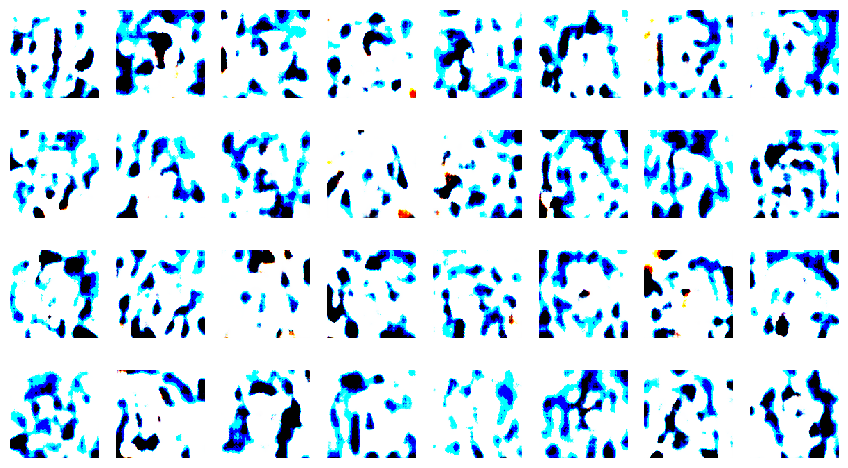

In [29]:
def generate_samples_from_normal_dist(decoder, n_samples=32, latent_dim=N, z_mu=0, z_sigma=1, device=DEVICE):
    """Generate images by sampling from latent space"""
    z = z_sigma * torch.randn((n_samples, latent_dim)).to(device) + z_mu
    
    with torch.inference_mode():
        generated_images = decoder(z)
        show_images(generated_images.to('cpu').detach(), num=n_samples, 
                   num_per_row=8, title=f'{N}_{MODEL_NAME}_generated_samples', save_fig=True, save_dir=f"./results/CelebA/{MODEL_NAME}/")
    
    return generated_images

gen_samples = generate_samples_from_normal_dist(dec_model, n_samples=32, latent_dim=N, z_mu=0, z_sigma=50)

In [22]:
def load_mnist_data(data_dir=DATA_DIR):
    """Load tinyCelebA dataset from files"""
    train_images = torch.load(os.path.join(data_dir, 'tinyCelebA_train_images.pt'))
    train_labels = torch.load(os.path.join(data_dir, 'tinyCelebA_train_labels.pt'))
    return train_images, train_labels

train_images, train_labels = load_mnist_data()
train_images.shape, train_labels.shape

(torch.Size([16000, 3, 128, 128]), torch.Size([16000, 40]))

Morphing visualization saved to ./results/CelebA/AE/256_AE_morphing_Smiling.png


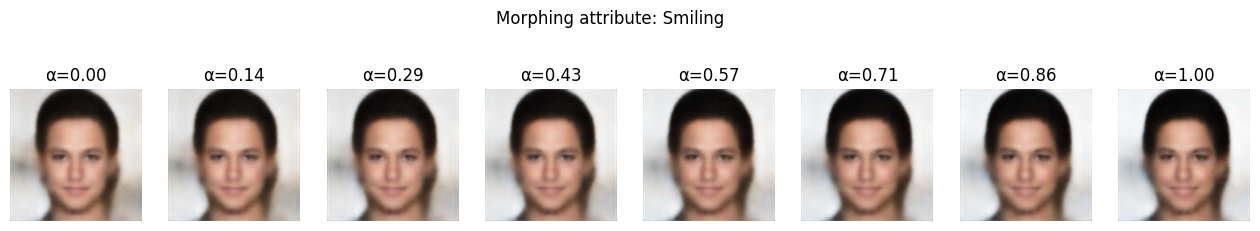

Morphing visualization saved to ./results/CelebA/AE/256_AE_morphing_Male.png


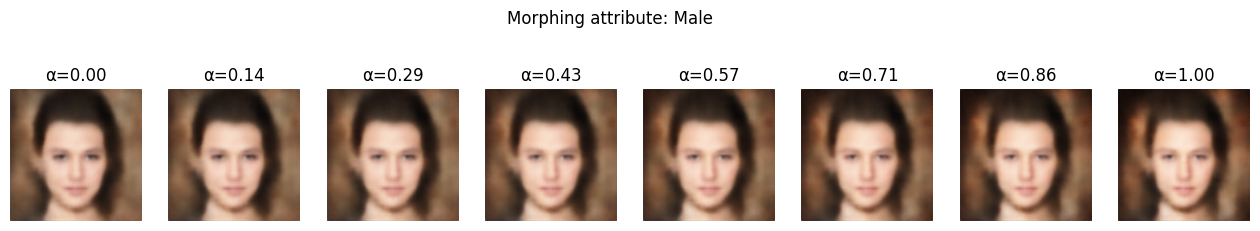

In [23]:
def morph_between_attributes(encoder, decoder, images, labels, 
                          target_attribute, samples_per_stage=8, num_steps=8,
                          attributes=CELEBA_ATTRIBUTES, device=DEVICE):
    """
    特定の属性を変化させるモーフィングを生成する関数
    
    Args:
        encoder: エンコーダーモデル
        decoder: デコーダーモデル
        images: 画像テンソル
        labels: 属性ラベルテンソル
        target_attribute: モーフィングしたい属性名（例：'Smiling', 'Male'）
        samples_per_stage: 各ステージ（属性あり/なし）で使用するサンプル数
        num_steps: モーフィングのステップ数
        attributes: 属性名のリスト
        device: 計算デバイス
    """
    # 属性インデックスを取得
    if target_attribute in attributes:
        attribute_idx = attributes.index(target_attribute)
    else:
        print(f"Error: Attribute '{target_attribute}' not found in the list.")
        return
    
    # 指定された属性に基づいてサンプルを選択
    pos_indices = torch.where(labels[:, attribute_idx] > 0)[0]
    neg_indices = torch.where(labels[:, attribute_idx] <= 0)[0]
    
    if len(pos_indices) < samples_per_stage or len(neg_indices) < samples_per_stage:
        print(f"Warning: Not enough samples with/without attribute '{target_attribute}'")
        samples_per_stage = min(len(pos_indices), len(neg_indices))
    
    # サンプルを選択
    pos_selected = pos_indices[:samples_per_stage]
    neg_selected = neg_indices[:samples_per_stage]
    
    # 潜在表現を取得
    with torch.inference_mode():
        # 属性ありの平均的な潜在表現
        z_pos_list = []
        for idx in pos_selected:
            img = images[idx:idx+1].to(device)
            z = encoder(img)
            z_pos_list.append(z)
        
        # 属性なしの平均的な潜在表現
        z_neg_list = []
        for idx in neg_selected:
            img = images[idx:idx+1].to(device)
            z = encoder(img)
            z_neg_list.append(z)
        
        # 平均を計算
        z_pos_mean = torch.mean(torch.cat(z_pos_list), dim=0, keepdim=True)
        z_neg_mean = torch.mean(torch.cat(z_neg_list), dim=0, keepdim=True)
        
        # 属性方向ベクトルを計算
        attribute_direction = z_pos_mean - z_neg_mean
        
        # モーフィング用に任意のサンプルを選択
        base_idx = neg_selected[0]  # 属性なしサンプルをベースに
        base_img = images[base_idx:base_idx+1].to(device)
        base_z = encoder(base_img)
        
        # モーフィング結果の表示用に画像を生成
        fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 3))
        
        for i in range(num_steps):
            # 補間の割合
            alpha = i / (num_steps - 1) if num_steps > 1 else 0
            
            # ベースの潜在表現に属性方向を徐々に加える
            interp_z = base_z + alpha * attribute_direction
            
            # 画像にデコード
            morphed_img = decoder(interp_z)
            img_np = morphed_img.cpu().squeeze().permute(1, 2, 0).detach().numpy()
            
            # 値を0-1の範囲に正規化
            img_np = np.clip(img_np, 0, 1)
            
            # 画像の表示
            axes[i].imshow(img_np)
            axes[i].set_title(f"α={alpha:.2f}")
            axes[i].axis('off')
        
        plt.suptitle(f"Morphing attribute: {target_attribute}")
        
        # 結果を保存
        os.makedirs(f"./results/CelebA/{MODEL_NAME}", exist_ok=True)
        save_path = os.path.join(f"./results/CelebA/{MODEL_NAME}", 
                               f"{N}_{MODEL_NAME}_morphing_{target_attribute}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Morphing visualization saved to {save_path}")
        
        plt.show()

# 使用例:
# 「Smiling」属性のモーフィング
morph_between_attributes(enc_model, dec_model, train_images, train_labels, 
                        target_attribute='Smiling', samples_per_stage=10, num_steps=8)

# 「Male」属性のモーフィング
morph_between_attributes(enc_model, dec_model, train_images, train_labels, 
                        target_attribute='Male', samples_per_stage=10, num_steps=8)
